In [1]:
import pandas as pd

import os

import copy

import random

import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'data'

df = pd.read_csv('data\\Friends_processed.csv')
df

,Text,Speaker
0,central perk.,break
1,there's nothing to tell! he's just some guy i ...,monica
2,"c'mon, you're going out with the guy! there's ...",joey
3,so does he have a hump? a hump and a hairpiece?,chandler
4,"wait, does he eat chalk?",phoebe
...,...,...
63484,"yeah, yeah, oh!",ross
63485,"oh! oh, i'm so happy.",rachel
63486,then i'm happy too.,ross
63487,estelle's memorial service. joey is giving a s...,break


Задаем основные параметры обработки:

- BREAK_LABEL - метка разрыва диалогов
- CHARACT - выбранный персонаж
- CONT_DEPTH - глубина контекста

In [3]:
BREAK_LABEL = 'break'
CHARACT = 'chandler'
REPL_DEPTH = 2
CONT_DEPTH = 8

Обрабатываем реплики персонажей следующим образом: в поле 'answer' записывается реплика выбранного персонажа. В поле 'question' записываются предшествующие реплики, количеством не более REPL_DEPTH, если в текущем диалоге появляется новая реплика персонажа, то предыдущая пара question-answer записывается в поле 'context', но не более CONT_DEPTH. Context работает по принципу, аналогичному стеку, но с максимальной глубиной CONT_DEPTH. Если количество пар question-answer в context становится более CONT_DEPTH, то при добавлении новой из него убирается самая первая пара.

Если диалог начинается с реплики выбранного персонажа, она не добавляется в датасет т.к. у нее нет предшествующей реплики

In [4]:
data = []
context = []
bank_repl = []

for index, row in tqdm(df.iterrows()):
    if row['Speaker'] == CHARACT and len(bank_repl) > 0:
        dialog = {}
        question = ''
        for i in range(min(len(bank_repl), REPL_DEPTH), 0, -1):
            question = question + ' ' + str(bank_repl[-i])
        dialog['question'] = question        
        dialog['answer'] = row['Text']
        dialog['context'] = copy.deepcopy(context)        
        if len(context) == CONT_DEPTH:
            context = context[1:]        
        context.append([question, row['Text']])            
        dialog['label'] = 1
        data.append(dialog)
        bank_repl.clear()
    else:    
        bank_repl.append(row['Text'])
    
    if row['Speaker'] == BREAK_LABEL:
        context.clear()
        bank_repl.clear()

63489it [00:03, 16507.84it/s]


Выводим несколько диалогов для проверки правильности работы алгоритма

In [5]:
data[0]

{'question': " there's nothing to tell! he's just some guy i work with! c'mon, you're going out with the guy! there's gotta be something wrong with him!",
 'answer': 'so does he have a hump? a hump and a hairpiece?',
 'context': [],
 'label': 1}

In [6]:
data[2]

{'question': " alright, so i'm back in high school, i'm standing in the middle of the cafeteria, and i realise i am totally naked. oh, yeah. had that dream.",
 'answer': "then i look down, and i realise there's a phone... there.",
 'context': [],
 'label': 1}

In [7]:
data[3]

{'question': ' instead of...?',
 'answer': "that's right.",
 'context': [[" alright, so i'm back in high school, i'm standing in the middle of the cafeteria, and i realise i am totally naked. oh, yeah. had that dream.",
   "then i look down, and i realise there's a phone... there."]],
 'label': 1}

Всего получается 7751 диалог с ответами

In [8]:
len(data)

7751

Строим диаграмму для распределения контекста по длине, видим, что все контексты длиннее максимальной глубины сконцентировались в контексте с длиной = CONT_DEPTH. Ради интереса я провел исследование, максимальная глубина контекста в датасете может составлять 84 предшествующие реплики для выбранного персонажа

In [9]:
len_cont = {}

for item in data:
    if len(item['context']) in len_cont:
        len_cont[len(item['context'])] += 1
    else:
        len_cont[len(item['context'])] = 1

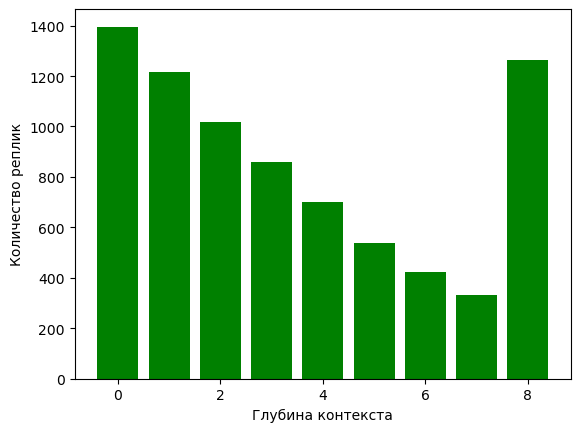

In [10]:
plt.ylabel('Количество реплик')
plt.xlabel('Глубина контекста')
plt.bar(len_cont.keys(), len_cont.values(), color='g');

Формируем корпус возможных ответов персонажа, выводим несколько примеров для проверки. Проверяем, что все ответные реплики персонажа попали в него. Сохраняем в бинарный файл

In [11]:
charact_corpus = []

for item in data:
    charact_corpus.append(str(item['answer']))

print(charact_corpus[0])
print(charact_corpus[1])
print(charact_corpus[2])

so does he have a hump? a hump and a hairpiece?
sounds like a date to me.
then i look down, and i realise there's a phone... there.


In [12]:
len(charact_corpus) == len(data)

True

In [13]:
MODEL_FOLDER = 'model'

In [14]:
try:
    os.mkdir(MODEL_FOLDER)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'model'


In [15]:
with open(os.path.join(MODEL_FOLDER, 'charact_corpus.pkl'), 'wb') as file:
    pickle.dump(charact_corpus, file)

Создаем корпус реплик для генерации негативных примеров ответов
- NEGATIVE_CHARACT - список персонажей для негативных примеров

In [16]:
NEGATIVE_CHARACT = ['rachel', 'phoebe', 'monica']

In [17]:
negative_charact_corpus = list(df[df['Speaker'].isin(NEGATIVE_CHARACT)]['Text'])

print(negative_charact_corpus[0])
print(negative_charact_corpus[1])
print(negative_charact_corpus[2])

there's nothing to tell! he's just some guy i work with!
wait, does he eat chalk?
just, 'cause, i don't want her to go through what i went through with carl- oh!


Добавляем к датасету негативные примеры следующим образом: задаем количество негативных примеров в виде доли от общего числа диалогов. Добавляем в датасет копии случайно выбранных диалогов с контекстом, заменяя правильный ответ на неправильный, случайно выбранный из заранее подготовленного корпуса ответов

In [18]:
NEGATIVE_SHARE = 0.5
number_of_negative = int(NEGATIVE_SHARE*len(data))
number_of_negative

3875

In [19]:
negative_dialogs = random.sample(range(0, len(data)), number_of_negative)

In [20]:
for negative_num in negative_dialogs:
    new_dialog = copy.deepcopy(data[negative_num])
    new_dialog['answer'] = negative_charact_corpus[random.randrange(len(negative_charact_corpus))]
    new_dialog['label'] = 0
    data.append(new_dialog)

Проверяем на первом диалоге из списка негативных. Видим, что алгоритм отработал верно

In [21]:
data[negative_dialogs[0]]

{'question': ' oh, chandler. hi chandler!',
 'answer': 'that’s… that’s was…',
 'context': [[' hey.', 'hey.'],
  [' oh. sorry!',
   'no-no-no, y’know what? i really shouldn’t have said that you were embarrassing me, i mean that really wasn’t cool. and if it makes you feel any better, i’ve had a really lousy day.'],
  [' me too.', 'yeah?']],
 'label': 1}

In [22]:
data[7751]

{'question': ' oh, chandler. hi chandler!',
 'answer': 'okay, umm, i’m gonna get my sweater.',
 'context': [[' hey.', 'hey.'],
  [' oh. sorry!',
   'no-no-no, y’know what? i really shouldn’t have said that you were embarrassing me, i mean that really wasn’t cool. and if it makes you feel any better, i’ve had a really lousy day.'],
  [' me too.', 'yeah?']],
 'label': 0}

Смотрим новую длину датасета и сохраняем его в бинарный файл

In [23]:
len(data)

11626

In [24]:
try:
    os.mkdir(DATA_FOLDER)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'data'


In [27]:
with open(os.path.join(DATA_FOLDER, 'data.pkl'), 'wb') as file:
    pickle.dump(data, file)